In [ ]:
!pip install np_utils
!pip install tensorflow==2.0.0
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
tf.compat.v1.disable_v2_behavior()
# from tensorflow.python.ops.numpy_ops import np_config

import os
import csv
import pywt
import time
import shap
import itertools
import collections
import numpy as np 
import pandas as pd 
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers
from sklearn.metrics import classification_report,precision_score,recall_score,accuracy_score,f1_score,roc_auc_score
# np_config.enable_numpy_behavior()
%matplotlib inline

In [ ]:
plt.rcParams["figure.figsize"] = (8,5)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/Colab_Datasets/mitbih_database/'
window_size = 180
maximum_counting = 10000

# ['N','V','/','A','F','~']#,'L','R',f','j','E','a']#,'J','Q','e','S']
# N=['N','L','R','e','j']
# S=['A','a','J','S']
# V=['V','E']
# F=['F']
# Q=['/','f','Q']

classes = ['N','L','R','e','j','A','a','J','S','V','E','F','/','f','Q']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

In [ ]:
# Read files
filenames = next(os.walk(path))[2]

# Split and save .csv , .txt 
records = list()
annotations = list()
filenames.sort()

In [ ]:
# segrefating filenames and annotations
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)

Total Records are : 48


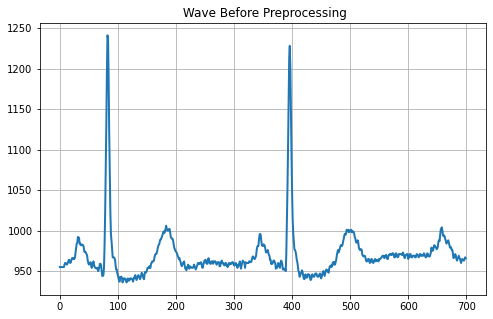

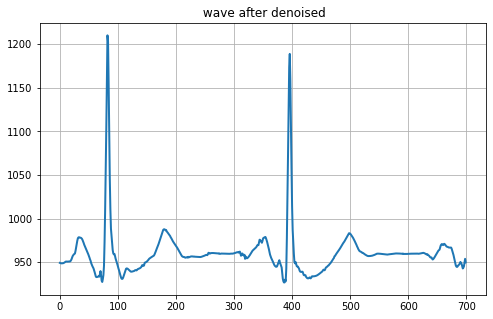

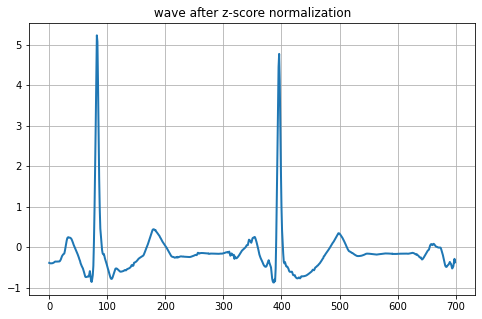

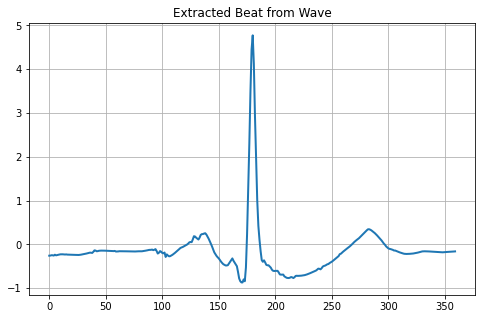

In [ ]:
def denoise(data): 
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        
    datarec = pywt.waverec(coeffs, 'sym4')
    
    return datarec

print("Total Records are :",len(records))

for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
            
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title( " Wave Before Preprocessing")
        plt.plot(signals[0:700])
        plt.show()
        
    signals = denoise(signals)
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title( " wave after denoised")
        plt.plot(signals[0:700])
        plt.show()
        
    signals = stats.zscore(signals)
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title( " wave after z-score normalization ")
        plt.plot(signals[0:700])
        plt.show()
    
    #Read anotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
#                 if count_classes[arrhythmia_index] > maximum_counting: # avoid overfitting
#                     pass
#                 else:
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]     ## REPLACE WITH R-PEAK DETECTION
                    # Plot an example to a beat    
                    if r is 1 and not example_beat_printed: 
                        plt.title("Extracted Beat from Wave")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)
                    y.append(arrhythmia_index)

In [ ]:
temp = np.array(y)
print("All classes are:",np.unique(temp))
print("Combining classes inform of AAII EC57 guidance:")
for i in range(0,len(y)):
  if y[i]==0 or y[i]==1 or y[i]==2 or y[i]==3 or y[i]==4:
    y[i]=0
  if y[i]==5 or y[i]==6 or y[i]==7 or y[i]==8:
    y[i]=1
  if y[i]==9 or y[i]==10:
    y[i]=2
  if y[i]==11:
    y[i]=3
  if y[i]==12 or y[i]==13 or y[i]==14:
    y[i]=4
print("Classes have been combined")

temp = np.array(y)
print("Combined Classes are:",np.unique(temp))


## Joining x and y
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])
print(np.shape(X))

All classes are: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Combining classes inform of AAII EC57 guidance:
Classes have been combined
Combined Classes are: [0 1 2 3 4]
(109438, 361)


# Classes Distribution & Re-Balancing

               360
(N)          90582
Unknown-(Q)   8038
VEB(V)        7235
SVEB(S)       2781
F(F)           802


<BarContainer object of 5 artists>

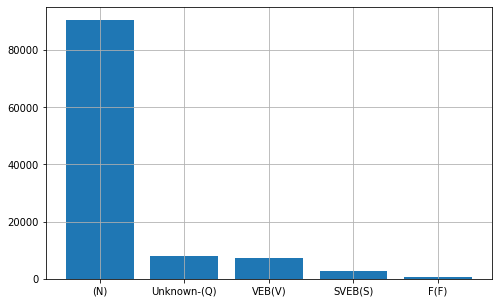

In [ ]:
X_train_df = pd.DataFrame(X)
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
per_class=pd.DataFrame(per_class).rename(index={0:'(N)',1:'SVEB(S)',2:'VEB(V)',3:'F(F)',4:'Unknown-(Q)'})
print(per_class)
plt.bar(per_class[360].index,per_class[360].values)

In [ ]:
# x = X_train_df.iloc[:,:X_train_df.shape[1]-1].values
# y = X_train_df.iloc[:,X_train_df.shape[1]-1].values

# x_train,x_test,y_train,y_test = train_test_split(x, y, random_state=0, stratify=y, shuffle=True,test_size=0.20)

# print("x_train and y_train shape : ", np.shape(x_train),np.shape(y_train))
# print("x_test and y_test shape : ", np.shape(x_test),np.shape(y_test))

In [ ]:
train, test = train_test_split(X_train_df, test_size=0.20,stratify=y)

print("X_train : ", np.shape(train))
print("X_test  : ", np.shape(test)) 

X_train :  (87550, 361)
X_test  :  (21888, 361)


               360
(N)          72465
SVEB(S)       8000
F(F)          8000
Unknown-(Q)   6430
VEB(V)        5788


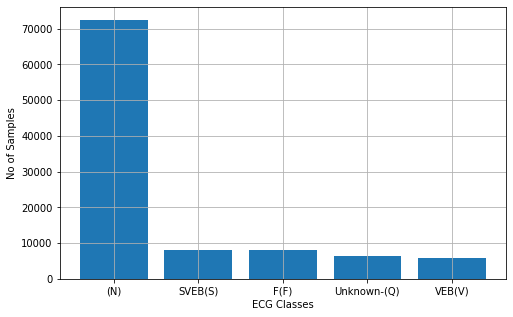

In [ ]:
df_1=train[train[train.shape[1]-1]==1]
df_2=train[train[train.shape[1]-1]==2]
df_3=train[train[train.shape[1]-1]==3]
df_4=train[train[train.shape[1]-1]==4]
df_0=train[train[train.shape[1]-1]==0]

# df_0_upsample=resample(df_0,replace=True,n_samples=6000,random_state=126)
df_1_upsample=resample(df_1,replace=True,n_samples=8000,random_state=122)
# df_2_upsample=resample(df_2,replace=True,n_samples=6000,random_state=123)
df_3_upsample=resample(df_3,replace=True,n_samples=8000,random_state=124)
# df_4_upsample=resample(df_4,replace=True,n_samples=6000,random_state=125)

# X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample,df_5_upsample])
train=pd.concat([df_0,df_1_upsample,df_2,df_3_upsample,df_4])

per_class = train[train.shape[1]-1].value_counts()
per_class=pd.DataFrame(per_class).rename(index={0:'(N)',1:'SVEB(S)',2:'VEB(V)',3:'F(F)',4:'Unknown-(Q)'})
print(per_class)
plt.bar(per_class[360].index,per_class[360].values)
plt.xlabel("ECG Classes")
plt.ylabel("No of Samples")
plt.show()

# Train-Test Split

In [ ]:
target_train=train[train.shape[1]-1]
target_test=test[test.shape[1]-1]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)
print(np.shape(y_train), np.shape(y_test))

(100683, 5) (21888, 5)


In [ ]:
train_x = train.iloc[:,:train.shape[1]-1].values
test_x = test.iloc[:,:test.shape[1]-1].values
x_train = train_x.reshape(len(train_x), train_x.shape[1],1)
x_test = test_x.reshape(len(test_x), test_x.shape[1],1)
print(np.shape(x_train), np.shape(x_test))

(100683, 360, 1) (21888, 360, 1)


In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=13, padding='same', activation='relu',input_shape=(360, 1)))
model.add(tf.keras.layers.AvgPool1D(pool_size=3, strides=2))
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=15, padding='same', activation='relu'))
model.add(tf.keras.layers.AvgPool1D(pool_size=3, strides=2))
model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=17, padding='same', activation='relu'))
model.add(tf.keras.layers.AvgPool1D(pool_size=3, strides=2))
# model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=19, padding='same', activation='relu'))
# model.add(tf.keras.layers.AvgPool1D(pool_size=3, strides=2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.Dense(35,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))
model.add(tf.keras.layers.Dense(5,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))
model.add(tf.keras.layers.Softmax())

# model.summary()

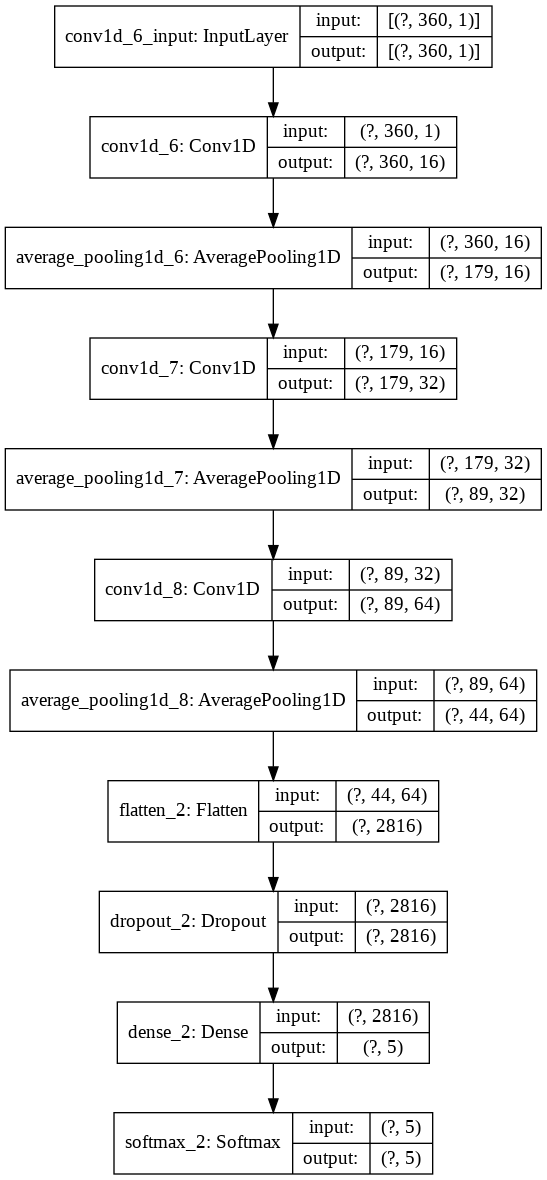

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True,rankdir="DR")

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

start = time.time()
history = model.fit(x_train, y_train, batch_size=36, epochs=50, verbose=1, validation_data=(x_test, y_test))
print("Total time: ", time.time() - start, "seconds")

Train on 100683 samples, validate on 21888 samples
Epoch 1/50
100683/100683 [==============================] - 131s 1ms/sample - loss: 0.2433 - acc: 0.9288 - val_loss: 0.1130 - val_acc: 0.9709
Epoch 2/50
100683/100683 [==============================] - 128s 1ms/sample - loss: 0.1393 - acc: 0.9589 - val_loss: 0.0778 - val_acc: 0.9805
Epoch 3/50
100683/100683 [==============================] - 129s 1ms/sample - loss: 0.1142 - acc: 0.9667 - val_loss: 0.0668 - val_acc: 0.9837
Epoch 4/50
100683/100683 [==============================] - 130s 1ms/sample - loss: 0.0974 - acc: 0.9716 - val_loss: 0.0701 - val_acc: 0.9819
Epoch 5/50
100683/100683 [==============================] - 130s 1ms/sample - loss: 0.0896 - acc: 0.9743 - val_loss: 0.0568 - val_acc: 0.9862
Epoch 6/50
100683/100683 [==============================] - 128s 1ms/sample - loss: 0.0812 - acc: 0.9767 - val_loss: 0.0556 - val_acc: 0.9870
Epoch 7/50
100683/100683 [==============================] - 130s 1ms/sample - loss: 0.0768 - acc:

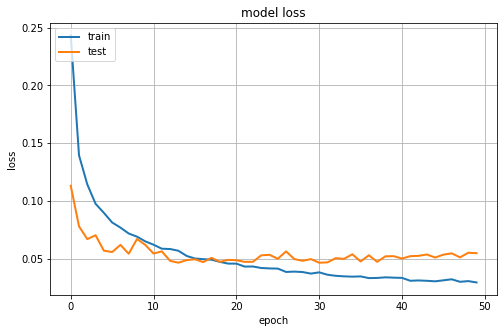

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

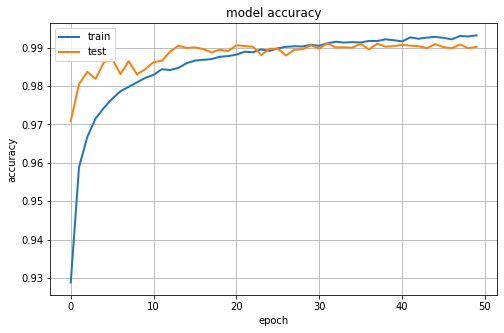

In [ ]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
score = model.evaluate(x_train, y_train)

print('Train Loss:', score[0])
print('Train accuracy:', score[1])

100683/100683 [==============================] - 38s 378us/sample - loss: 0.0153 - acc: 0.9980
Train Loss: 0.015259400632405922
Train accuracy: 0.99798375


In [ ]:
from sklearn.metrics import classification_report
y_pred=model.predict(x_train)
y_pred=np.argmax(y_pred, axis=1)
y_train=np.argmax(y_train, axis=1)
print(classification_report(y_train,y_pred))

In [ ]:
print("Accuracy_score of training_set:",accuracy_score(y_train,y_pred))
print("Precision_score of training_set:",precision_score(y_train,y_pred,average='weighted'))
print("Recall_score of training_set:",recall_score(y_train,y_pred,average='weighted'))
print("F1_score of training_set:",f1_score(y_train,y_pred,average='weighted'))

Accuracy_score of training_set: 0.9979837708451278
Precision_score of training_set: 0.9979909145087352
Recall_score of training_set: 0.9979837708451278
F1_score of training_set: 0.9979834530465705


In [ ]:
score = model.evaluate(x_test, y_test)

print('Test Loss:', score[0])
print('Test accuracy:', score[1])

21888/21888 [==============================] - 8s 381us/sample - loss: 0.0546 - acc: 0.9902
Test Loss: 0.054614704151294734
Test accuracy: 0.9901773


In [ ]:
from sklearn.metrics import classification_report
y_pred=model.predict(x_test)
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)
print(classification_report(y_test,y_pred))

In [ ]:
print("Accuracy_score of training_set:",accuracy_score(y_test,y_pred))
print("Precision_score of training_set:",precision_score(y_test,y_pred,average='weighted'))
print("Recall_score of training_set:",recall_score(y_test,y_pred,average='weighted'))
print("F1_score of training_set:",f1_score(y_test,y_pred,average='weighted'))

Accuracy_score of training_set: 0.9901772660818714
Precision_score of training_set: 0.9903382804869229
Recall_score of training_set: 0.9901772660818714
F1_score of training_set: 0.9902200391588254


In [ ]:
start = time.time()

path = '/content/drive/MyDrive/Colab_Datasets/mitbih_database/'
window_size = 180
maximum_counting = 10000

# ['N','V','/','A','F','~']#,'L','R',f','j','E','a']#,'J','Q','e','S']
# N=['N','L','R','e','j']
# S=['A','a','J','S']
# V=['V','E']
# F=['F']
# Q=['/','f','Q']

classes = ['N','L','R','e','j','A','a','J','S','V','E','F','/','f','Q']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

# Read files
filenames = next(os.walk(path))[2]

# Split and save .csv , .txt 
records = list()
annotations = list()
filenames.sort()

# segrefating filenames and annotations
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)

def denoise(data): 
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        
    datarec = pywt.waverec(coeffs, 'sym4')
    
    return datarec

print("Total Records are :",len(records))

for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
          
    
    #Read anotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
#                 if count_classes[arrhythmia_index] > maximum_counting: # avoid overfitting
#                     pass
#                 else:
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]     ## REPLACE WITH R-PEAK DETECTION

                    X.append(beat)
                    y.append(arrhythmia_index)

# temp = np.array(y)
# print("All classes are:",np.unique(temp))
# print("Combining classes inform of AAII EC57 guidance:")
# for i in range(0,len(y)):
#   if y[i]==0 or y[i]==1 or y[i]==2 or y[i]==3 or y[i]==4:
#     y[i]=0
#   if y[i]==5 or y[i]==6 or y[i]==7 or y[i]==8:
#     y[i]=1
#   if y[i]==9 or y[i]==10:
#     y[i]=2
#   if y[i]==11:
#     y[i]=3
#   if y[i]==12 or y[i]==13 or y[i]==14:
#     y[i]=4
# print("Classes have been combined")

X=(pd.DataFrame(X)).values
X = X.reshape(len(X), X.shape[1],1)


dummy=model.predict(X)

print("Total time taken for prediction: ", time.time() - start, "seconds")
print("Total time taken for prediction of 1 sample: ", (time.time() - start)/len(X), "seconds")
print("Total time taken for prediction of 1 Patient: ", (time.time() - start)/48, "seconds")

Total Records are : 48
Total time taken for prediction:  100.66333317756653 seconds
Total time taken for prediction of 1 sample:  0.0009198233115681562 seconds
Total time taken for prediction of 1 Patient:  2.097160483400027 seconds


In [ ]:
background = x_train[:100].astype(np.float32)
explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(x_test[:10])

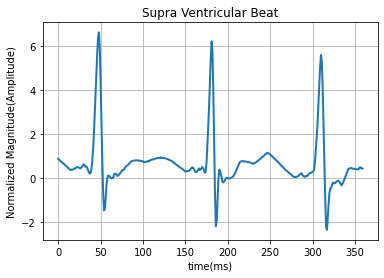

In [ ]:
plt.plot(x_test[1])
plt.title("Normal")
plt.xlabel("time(ms)")
plt.ylabel("Normalized Magnitude(Amplitude)")
plt.show()

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], x_test[1])


In [ ]:
plt.plot(x_test[9])
plt.title("Supra Ventricular Beat")
plt.xlabel("time(ms)")
plt.ylabel("Normalized Magnitude(Amplitude)")
plt.show()

9 1


In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], x_test[9])

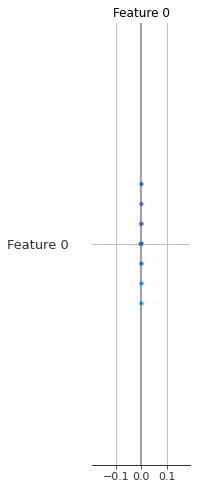

In [ ]:
shap.summary_plot(shap_values[1],test_x[:10])